In [1]:
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.utils
import matplotlib.pyplot as plt
import seaborn as sns
#import cv2
from sklearn import tree, ensemble
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.autograd import Variable
import torchvision.utils
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.optim as optim

In [3]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imputer = SimpleImputer(strategy="median")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [4]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ["Female", "Male"]
        for i in range(len(column_names)):
            X[column_names[i]] = matrix.T[i]
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ["France", "Ireland", "Southham"]
        for i in range(len(column_names)):
            X[column_names[i]] = matrix.T[i]
        matrix = encoder.fit_transform(X[['Pclass']]).toarray()
        column_names = ["UpperClass", "MidClass", "WorkClass"]
        for i in range(len(column_names)):
            X[column_names[i]] = matrix.T[i]
        return X

In [5]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(["Name", "Ticket", "Sex", "Embarked", "Pclass", "Parch", "SibSp", "Cabin", "Age", "Fare"], axis=1)

In [6]:
titanic_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
print(test_data.head(11))
titanic_data.head(11)

    PassengerId  Pclass                                          Name     Sex  \
0           892       3                              Kelly, Mr. James    male   
1           893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2           894       2                     Myles, Mr. Thomas Francis    male   
3           895       3                              Wirz, Mr. Albert    male   
4           896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
5           897       3                    Svensson, Mr. Johan Cervin    male   
6           898       3                          Connolly, Miss. Kate  female   
7           899       2                  Caldwell, Mr. Albert Francis    male   
8           900       3     Abrahim, Mrs. Joseph (Sophie Halaut Easu)  female   
9           901       3                       Davies, Mr. John Samuel    male   
10          902       3                              Ilieff, Mr. Ylio    male   

     Age  SibSp  Parch     

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
print(test_data.info())
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pcl

In [8]:
count = len(titanic_data)
print(count)

891


In [9]:
count_T = len(test_data)
print(count_T)

418


In [10]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [11]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


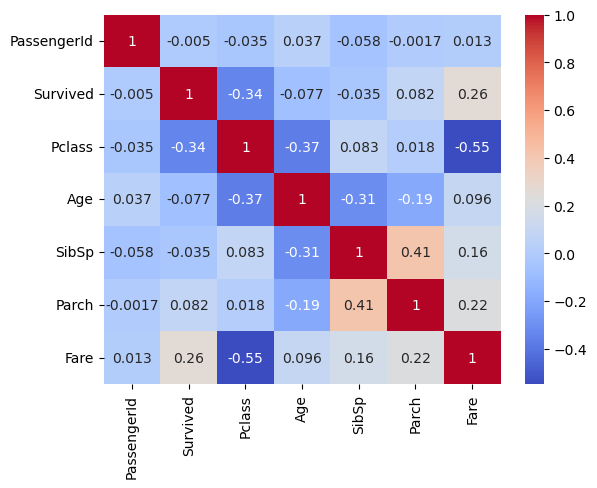

In [12]:
numerical_df = titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [13]:
columns = titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(titanic_data[titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(titanic_data[titanic_data[col].isnull()])
    if (col == 'Age'):
        AgeNaN = titanic_data[titanic_data[col].isnull()]
    if (col == 'Cabin'):
        CabinNaN = titanic_data[titanic_data[col].isnull()]
print('There are', len(titanic_data[titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 12
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Pclass column is: 0
Number of missing training values in the Name column is: 0
Number of missing training values in the Sex column is: 0
Number of missing training values in the Age column is: 177
Number of missing training values in the SibSp column is: 0
Number of missing training values in the Parch column is: 0
Number of missing training values in the Ticket column is: 0
Number of missing training values in the Fare column is: 0
Number of missing training values in the Cabin column is: 687
Number of missing training values in the Embarked column is: 2
     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelso

In [14]:
columns = test_data.columns.values
print('Number of columns in the test data is:', (len(columns)))
for col in columns:
    print('Number of missing test values in the', col, 'column is:', len(test_data[test_data[col].isnull()]))
    if (col == 'Embarked'):
        print(test_data[test_data[col].isnull()])
    if (col == 'Age'):
        AgeNaN_T = test_data[test_data[col].isnull()]
    if (col == 'Cabin'):
        CabinNaN_T = test_data[test_data[col].isnull()]
print('There are', len(test_data[test_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the test data is: 11
Number of missing test values in the PassengerId column is: 0
Number of missing test values in the Pclass column is: 0
Number of missing test values in the Name column is: 0
Number of missing test values in the Sex column is: 0
Number of missing test values in the Age column is: 86
Number of missing test values in the SibSp column is: 0
Number of missing test values in the Parch column is: 0
Number of missing test values in the Ticket column is: 0
Number of missing test values in the Fare column is: 1
Number of missing test values in the Cabin column is: 327
Number of missing test values in the Embarked column is: 0
Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []
There are 331 rows with missing values


In [15]:
AgeNaN.index

Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
       ...
       832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
      dtype='int64', length=177)

In [16]:
AgeNaN_T.index

Index([ 10,  22,  29,  33,  36,  39,  41,  47,  54,  58,  65,  76,  83,  84,
        85,  88,  91,  93, 102, 107, 108, 111, 116, 121, 124, 127, 132, 133,
       146, 148, 151, 160, 163, 168, 170, 173, 183, 188, 191, 199, 200, 205,
       211, 216, 219, 225, 227, 233, 243, 244, 249, 255, 256, 265, 266, 267,
       268, 271, 273, 274, 282, 286, 288, 289, 290, 292, 297, 301, 304, 312,
       332, 339, 342, 344, 357, 358, 365, 366, 380, 382, 384, 408, 410, 413,
       416, 417],
      dtype='int64')

In [17]:
AgeNaN.head(11)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C


In [18]:
AgeNaN_T.head(11)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S
29,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S
39,931,3,"Hee, Mr. Ling",male,NaN,0,0,1601,56.4958,NaN,S
41,933,1,"Franklin, Mr. Thomas Parham",male,NaN,0,0,113778,26.5500,D34,S
47,939,3,"Shaughnessy, Mr. Patrick",male,NaN,0,0,370374,7.7500,NaN,Q
54,946,2,"Mangiavacchi, Mr. Serafino Emilio",male,NaN,0,0,SC/A.3 2861,15.5792,NaN,C
58,950,3,"Davison, Mr. Thomas Henry",male,NaN,1,0,386525,16.1000,NaN,S


In [19]:
pipeline2 = Pipeline([
    ('imputer', AgeImputer()),
    ('encoder', FeatureEncoder()),
    ('dropper', FeatureDropper())
])

In [20]:
pipeline1 = Pipeline([
    ('encoder', FeatureEncoder()),
    ('dropper', FeatureDropper())
])

In [21]:
strat_titanic_data = pipeline1.fit_transform(titanic_data)
strat_test_data = pipeline2.fit_transform(test_data)

In [22]:
strat_titanic_data["Female"] = strat_titanic_data["Female"].astype(int)
strat_titanic_data["Male"] = strat_titanic_data["Male"].astype(int)
strat_titanic_data["France"] = strat_titanic_data["France"].astype(int)
strat_titanic_data["Ireland"] = strat_titanic_data["Ireland"].astype(int)
strat_titanic_data["Southham"] = strat_titanic_data["Southham"].astype(int)
strat_titanic_data["UpperClass"] = strat_titanic_data["UpperClass"].astype(int)
strat_titanic_data["MidClass"] = strat_titanic_data["MidClass"].astype(int)
strat_titanic_data["WorkClass"] = strat_titanic_data["WorkClass"].astype(int)
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
0,1,0,0,1,0,0,1,0,0,1
1,2,1,1,0,1,0,0,1,0,0
2,3,1,1,0,0,0,1,0,0,1
3,4,1,1,0,0,0,1,1,0,0
4,5,0,0,1,0,0,1,0,0,1
5,6,0,0,1,0,1,0,0,0,1
6,7,0,0,1,0,0,1,1,0,0
7,8,0,0,1,0,0,1,0,0,1
8,9,1,1,0,0,0,1,0,0,1
9,10,1,1,0,1,0,0,0,1,0


In [23]:
strat_test_data["Female"] = strat_test_data["Female"].astype(int)
strat_test_data["Male"] = strat_test_data["Male"].astype(int)
strat_test_data["France"] = strat_test_data["France"].astype(int)
strat_test_data["Ireland"] = strat_test_data["Ireland"].astype(int)
strat_test_data["Southham"] = strat_test_data["Southham"].astype(int)
strat_test_data["UpperClass"] = strat_test_data["UpperClass"].astype(int)
strat_test_data["MidClass"] = strat_test_data["MidClass"].astype(int)
strat_test_data["WorkClass"] = strat_test_data["WorkClass"].astype(int)
strat_test_data.head(11)

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
0,892,0,1,0,1,0,0,0,1
1,893,1,0,0,0,1,0,0,1
2,894,0,1,0,1,0,0,1,0
3,895,0,1,0,0,1,0,0,1
4,896,1,0,0,0,1,0,0,1
5,897,0,1,0,0,1,0,0,1
6,898,1,0,0,1,0,0,0,1
7,899,0,1,0,0,1,0,1,0
8,900,1,0,1,0,0,0,0,1
9,901,0,1,0,0,1,0,0,1


In [24]:
strat_titanic_data.iloc[AgeNaN.head(11).index]

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
5,6,0,0,1,0,1,0,0,0,1
17,18,1,0,1,0,0,1,0,1,0
19,20,1,1,0,1,0,0,0,0,1
26,27,0,0,1,1,0,0,0,0,1
28,29,1,1,0,0,1,0,0,0,1
29,30,0,0,1,0,0,1,0,0,1
31,32,1,1,0,1,0,0,1,0,0
32,33,1,1,0,0,1,0,0,0,1
36,37,1,0,1,1,0,0,0,0,1
42,43,0,0,1,1,0,0,0,0,1


In [25]:
strat_test_data.iloc[AgeNaN_T.head(11).index]

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
10,902,0,1,0,0,1,0,0,1
22,914,1,0,0,0,1,1,0,0
29,921,0,1,1,0,0,0,0,1
33,925,1,0,0,0,1,0,0,1
36,928,1,0,0,0,1,0,0,1
39,931,0,1,0,0,1,0,0,1
41,933,0,1,0,0,1,1,0,0
47,939,0,1,0,1,0,0,0,1
54,946,0,1,1,0,0,0,1,0
58,950,0,1,0,0,1,0,0,1


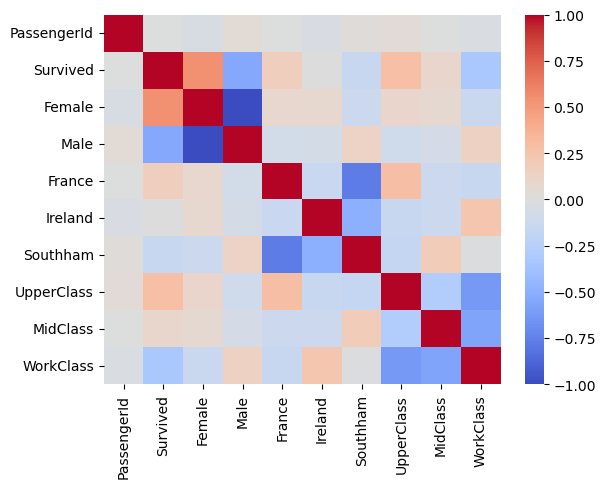

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
PassengerId,1.000000,-0.005007,-0.042939,0.042939,-0.001205,-0.033606,0.022148,0.034303,-0.000086,-0.029486
Survived,-0.005007,1.000000,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.285904,0.093349,-0.322308
Female,-0.042939,0.543351,1.000000,-1.000000,0.082853,0.074115,-0.125722,0.098013,0.064746,-0.137143
Male,0.042939,-0.543351,-1.000000,1.000000,-0.082853,-0.074115,0.125722,-0.098013,-0.064746,0.137143
France,-0.001205,0.168240,0.082853,-0.082853,1.000000,-0.148258,-0.778359,0.296423,-0.125416,-0.153329
Ireland,-0.033606,0.003650,0.074115,-0.074115,-0.148258,1.000000,-0.496624,-0.155342,-0.127301,0.237449
Southham,0.022148,-0.155660,-0.125722,0.125722,-0.778359,-0.496624,1.000000,-0.170379,0.192061,-0.009511
UpperClass,0.034303,0.285904,0.098013,-0.098013,0.296423,-0.155342,-0.170379,1.000000,-0.288585,-0.626738
MidClass,-0.000086,0.093349,0.064746,-0.064746,-0.125416,-0.127301,0.192061,-0.288585,1.000000,-0.565210
WorkClass,-0.029486,-0.322308,-0.137143,0.137143,-0.153329,0.237449,-0.009511,-0.626738,-0.565210,1.000000


In [26]:
numerical_df = strat_titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix

In [27]:
columns = strat_titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_titanic_data[strat_titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_titanic_data[strat_titanic_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
print('There are', len(strat_titanic_data[strat_titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 10
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
There are 0 rows with missing values


In [28]:
columns = strat_test_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_test_data[strat_test_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_test_data[strat_test_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_test_data[strat_test_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_ttest_data[strat_test_data[col].isnull()]
print('There are', len(strat_test_data[strat_test_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 9
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
There are 0 rows with missing values


In [29]:
titanic_data["Fare"].median

<bound method Series.median of 0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 891, dtype: float64>

In [30]:
test_data["Fare"].median

<bound method Series.median of 0        7.8292
1        7.0000
2        9.6875
3        8.6625
4       12.2875
         ...   
413      8.0500
414    108.9000
415      7.2500
416      8.0500
417     22.3583
Name: Fare, Length: 418, dtype: float64>

In [31]:
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
0,1,0,0,1,0,0,1,0,0,1
1,2,1,1,0,1,0,0,1,0,0
2,3,1,1,0,0,0,1,0,0,1
3,4,1,1,0,0,0,1,1,0,0
4,5,0,0,1,0,0,1,0,0,1
5,6,0,0,1,0,1,0,0,0,1
6,7,0,0,1,0,0,1,1,0,0
7,8,0,0,1,0,0,1,0,0,1
8,9,1,1,0,0,0,1,0,0,1
9,10,1,1,0,1,0,0,0,1,0


In [32]:
DeckA = np.eye(count_T, 1, dtype=int)
DeckB = np.eye(count_T, 1, dtype=int) 
DeckC = np.eye(count_T, 1, dtype=int)
DeckD = np.eye(count_T, 1, dtype=int)
DeckE = np.eye(count_T, 1, dtype=int)
DeckF = np.eye(count_T, 1, dtype=int)
DeckG = np.eye(count_T, 1, dtype=int)
has_A = test_data["Cabin"].str.contains('A')
has_B = test_data["Cabin"].str.contains('B')
has_C = test_data["Cabin"].str.contains('C')
has_D = test_data["Cabin"].str.contains('D')
has_E = test_data["Cabin"].str.contains('E')
has_F = test_data["Cabin"].str.contains('F')
has_G = test_data["Cabin"].str.contains('G')

for i in range(len(strat_test_data)):
    if (has_A[i] == True):
        DeckA[i] = 1
    elif (has_B[i] == True):
        DeckB[i] = 1
    elif (has_C[i] == True):
        DeckC[i]=1
    elif (has_D[i] == True):
        DeckD[i] = 1
    elif (has_E[i] == True):
        DeckE[i] = 1
    elif (has_F[i] == True):
        DeckF[i] = 1
    elif (has_G[i] == True):
        DeckG[i] = 1
    else:
        DeckA[i] = 0
        DeckB[i] = 0
        DeckC[i] = 0
        DeckD[i] = 0
        DeckE[i] = 0
        DeckF[i] = 0
        DeckG[i] = 0

DeckA = pd.DataFrame(DeckA)
DeckB = pd.DataFrame(DeckB)
DeckC = pd.DataFrame(DeckC)
DeckD = pd.DataFrame(DeckD)
DeckE = pd.DataFrame(DeckE)
DeckF = pd.DataFrame(DeckF)
DeckG = pd.DataFrame(DeckG)

strat_test_data["DeckA"] = DeckA
strat_test_data["DeckB"] = DeckB
strat_test_data["DeckC"] = DeckC
strat_test_data["DeckD"] = DeckD
strat_test_data["DeckE"] = DeckE
strat_test_data["DeckF"] = DeckF
strat_test_data["DeckG"] = DeckG
print(strat_test_data["DeckA"].value_counts())
print(strat_test_data["DeckB"].value_counts())
print(strat_test_data["DeckC"].value_counts())
print(strat_test_data["DeckD"].value_counts())
print(strat_test_data["DeckE"].value_counts())
print(strat_test_data["DeckF"].value_counts())
print(strat_test_data["DeckG"].value_counts())

DeckA
0    411
1      7
Name: count, dtype: int64
DeckB
0    400
1     18
Name: count, dtype: int64
DeckC
0    383
1     35
Name: count, dtype: int64
DeckD
0    405
1     13
Name: count, dtype: int64
DeckE
0    407
1     11
Name: count, dtype: int64
DeckF
0    412
1      6
Name: count, dtype: int64
DeckG
0    417
1      1
Name: count, dtype: int64


In [33]:
DeckA = np.eye(count, 1, dtype=int)
DeckB = np.eye(count, 1, dtype=int) 
DeckC = np.eye(count, 1, dtype=int)
DeckD = np.eye(count, 1, dtype=int)
DeckE = np.eye(count, 1, dtype=int)
DeckF = np.eye(count, 1, dtype=int)
DeckG = np.eye(count, 1, dtype=int)
has_A = titanic_data["Cabin"].str.contains('A')
has_B = titanic_data["Cabin"].str.contains('B')
has_C = titanic_data["Cabin"].str.contains('C')
has_D = titanic_data["Cabin"].str.contains('D')
has_E = titanic_data["Cabin"].str.contains('E')
has_F = titanic_data["Cabin"].str.contains('F')
has_G = titanic_data["Cabin"].str.contains('G')

for i in range(len(strat_titanic_data)):
    if (has_A[i] == True):
        DeckA[i] = 1
    elif (has_B[i] == True):
        DeckB[i] = 1
    elif (has_C[i] == True):
        DeckC[i]=1
    elif (has_D[i] == True):
        DeckD[i] = 1
    elif (has_E[i] == True):
        DeckE[i] = 1
    elif (has_F[i] == True):
        DeckF[i] = 1
    elif (has_G[i] == True):
        DeckG[i] = 1
    else:
        DeckA[i] = 0
        DeckB[i] = 0
        DeckC[i] = 0
        DeckD[i] = 0
        DeckE[i] = 0
        DeckF[i] = 0
        DeckG[i] = 0

DeckA = pd.DataFrame(DeckA)
DeckB = pd.DataFrame(DeckB)
DeckC = pd.DataFrame(DeckC)
DeckD = pd.DataFrame(DeckD)
DeckE = pd.DataFrame(DeckE)
DeckF = pd.DataFrame(DeckF)
DeckG = pd.DataFrame(DeckG)

strat_titanic_data["DeckA"] = DeckA
strat_titanic_data["DeckB"] = DeckB
strat_titanic_data["DeckC"] = DeckC
strat_titanic_data["DeckD"] = DeckD
strat_titanic_data["DeckE"] = DeckE
strat_titanic_data["DeckF"] = DeckF
strat_titanic_data["DeckG"] = DeckG
print(strat_titanic_data["DeckA"].value_counts())
print(strat_titanic_data["DeckB"].value_counts())
print(strat_titanic_data["DeckC"].value_counts())
print(strat_titanic_data["DeckD"].value_counts())
print(strat_titanic_data["DeckE"].value_counts())
print(strat_titanic_data["DeckF"].value_counts())
print(strat_titanic_data["DeckG"].value_counts())

DeckA
0    876
1     15
Name: count, dtype: int64
DeckB
0    844
1     47
Name: count, dtype: int64
DeckC
0    832
1     59
Name: count, dtype: int64
DeckD
0    858
1     33
Name: count, dtype: int64
DeckE
0    858
1     33
Name: count, dtype: int64
DeckF
0    879
1     12
Name: count, dtype: int64
DeckG
0    887
1      4
Name: count, dtype: int64


In [34]:
strat_test_data.head(11)

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,DeckD,DeckE,DeckF,DeckG
0,892,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
1,893,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,894,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
3,895,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
4,896,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
5,897,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
6,898,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
7,899,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0
8,900,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
9,901,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0


In [35]:
strat_titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
 2   Female       891 non-null    int64
 3   Male         891 non-null    int64
 4   France       891 non-null    int64
 5   Ireland      891 non-null    int64
 6   Southham     891 non-null    int64
 7   UpperClass   891 non-null    int64
 8   MidClass     891 non-null    int64
 9   WorkClass    891 non-null    int64
 10  DeckA        891 non-null    int64
 11  DeckB        891 non-null    int64
 12  DeckC        891 non-null    int64
 13  DeckD        891 non-null    int64
 14  DeckE        891 non-null    int64
 15  DeckF        891 non-null    int64
 16  DeckG        891 non-null    int64
dtypes: int64(17)
memory usage: 118.5 KB


In [36]:
strat_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Female       418 non-null    int64
 2   Male         418 non-null    int64
 3   France       418 non-null    int64
 4   Ireland      418 non-null    int64
 5   Southham     418 non-null    int64
 6   UpperClass   418 non-null    int64
 7   MidClass     418 non-null    int64
 8   WorkClass    418 non-null    int64
 9   DeckA        418 non-null    int64
 10  DeckB        418 non-null    int64
 11  DeckC        418 non-null    int64
 12  DeckD        418 non-null    int64
 13  DeckE        418 non-null    int64
 14  DeckF        418 non-null    int64
 15  DeckG        418 non-null    int64
dtypes: int64(16)
memory usage: 52.4 KB


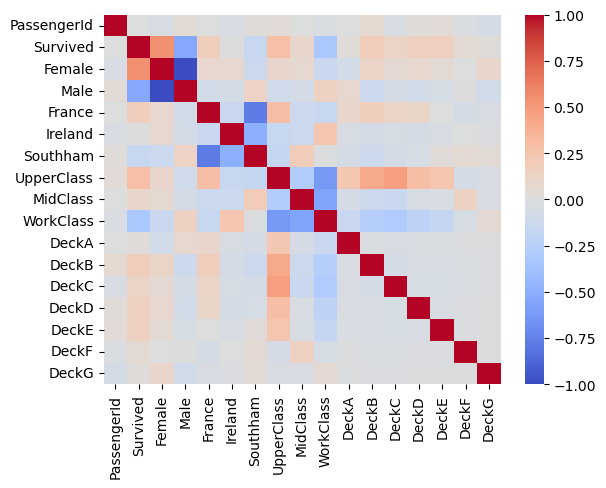

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,DeckD,DeckE,DeckF,DeckG
PassengerId,1.000000,-0.005007,-0.042939,0.042939,-0.001205,-0.033606,0.022148,0.034303,-0.000086,-0.029486,-0.003256,0.069552,-0.040957,0.022828,0.034404,-0.025212,-0.060049
Survived,-0.005007,1.000000,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.285904,0.093349,-0.322308,0.022287,0.175095,0.114652,0.150716,0.150716,0.047930,0.016040
Female,-0.042939,0.543351,1.000000,-1.000000,0.082853,0.074115,-0.125722,0.098013,0.064746,-0.137143,-0.078271,0.109689,0.058649,0.079248,0.054368,-0.004667,0.091031
Male,0.042939,-0.543351,-1.000000,1.000000,-0.082853,-0.074115,0.125722,-0.098013,-0.064746,0.137143,0.078271,-0.109689,-0.058649,-0.079248,-0.054368,0.004667,-0.091031
France,-0.001205,0.168240,0.082853,-0.082853,1.000000,-0.148258,-0.778359,0.296423,-0.125416,-0.153329,0.093040,0.168642,0.113952,0.102977,-0.003376,-0.056322,-0.032371
Ireland,-0.033606,0.003650,0.074115,-0.074115,-0.148258,1.000000,-0.496624,-0.155342,-0.127301,0.237449,-0.040246,-0.072579,-0.049776,-0.060318,-0.039167,-0.001283,-0.020654
Southham,0.022148,-0.155660,-0.125722,0.125722,-0.778359,-0.496624,1.000000,-0.170379,0.192061,-0.009511,-0.055383,-0.123057,-0.066995,-0.051139,0.028520,0.050608,0.041589
UpperClass,0.034303,0.285904,0.098013,-0.098013,0.296423,-0.155342,-0.170379,1.000000,-0.288585,-0.626738,0.231323,0.417160,0.470749,0.291218,0.235748,-0.066095,-0.037988
MidClass,-0.000086,0.093349,0.064746,-0.064746,-0.125416,-0.127301,0.192061,-0.288585,1.000000,-0.565210,-0.066756,-0.120386,-0.135851,-0.041325,-0.041325,0.132819,-0.034258
WorkClass,-0.029486,-0.322308,-0.137143,0.137143,-0.153329,0.237449,-0.009511,-0.626738,-0.565210,1.000000,-0.144979,-0.261450,-0.295036,-0.217282,-0.169489,-0.051148,0.060612


In [37]:
numerical_df = strat_titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix

In [38]:
Infant = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] <= 5):
        Infant[i] = 1
    else:
        Infant[i] = 0
Infant = pd.DataFrame(Infant)
strat_titanic_data["Infant"] = Infant
print(strat_titanic_data["Infant"].value_counts())

Infant
0    847
1     44
Name: count, dtype: int64


In [39]:
Infant = np.eye(count_T, 1, dtype=int)
for i in range(count_T):
    if (test_data.iloc[i]["Age"] <= 5):
        Infant[i] = 1
    else:
        Infant[i] = 0
Infant = pd.DataFrame(Infant)
strat_test_data["Infant"] = Infant
print(strat_test_data["Infant"].value_counts())

Infant
0    406
1     12
Name: count, dtype: int64


In [40]:
Older = np.eye(count, 1, dtype=int)
VOld = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 63) & (titanic_data.iloc[i]["Age"] < 75):
        Older[i] = 1
    elif (titanic_data.iloc[i]["Age"] > 74):
        VOld[i] = 1
    else:
        Older[i] = 0
        VOld[i] = 0
Older = pd.DataFrame(Older)
VOld = pd.DataFrame(VOld)
strat_titanic_data["Older"] = Older
strat_titanic_data["VOld"] = VOld
print(strat_titanic_data["Older"].value_counts())
print(strat_titanic_data["VOld"].value_counts())

Older
0    879
1     12
Name: count, dtype: int64
VOld
0    890
1      1
Name: count, dtype: int64


In [41]:
Older = np.eye(count_T, 1, dtype=int)
VOld = np.eye(count_T, 1, dtype=int)
for i in range(count_T):
    if (test_data.iloc[i]["Age"] > 63) & (test_data.iloc[i]["Age"] < 75):
        Older[i] = 1
    elif (test_data.iloc[i]["Age"] > 74):
        VOld[i] = 1
    else:
        Older[i] = 0
        VOld[i] = 0
Older = pd.DataFrame(Older)
VOld = pd.DataFrame(VOld)
strat_test_data["Older"] = Older
strat_test_data["VOld"] = VOld
print(strat_test_data["Older"].value_counts())
print(strat_test_data["VOld"].value_counts())

Older
0    414
1      4
Name: count, dtype: int64
VOld
0    417
1      1
Name: count, dtype: int64


In [42]:
Teen = np.eye(count, 1, dtype=int)
Child = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 12) & (titanic_data.iloc[i]["Age"] <= 18):
        Teen[i] = 1
    elif (titanic_data.iloc[i]["Age"] > 5) & (titanic_data.iloc[i]["Age"] <= 12):
        Child[i] = 1     
    else:
        Teen[i] = 0
        Child[i] = 0
Teen = pd.DataFrame(Teen)
Child = pd.DataFrame(Child)
strat_titanic_data["Teen"] = Teen
strat_titanic_data["Child"] = Child
print(strat_titanic_data["Teen"].value_counts())
print(strat_titanic_data["Child"].value_counts())

Teen
0    821
1     70
Name: count, dtype: int64
Child
0    866
1     25
Name: count, dtype: int64


In [43]:
Teen = np.eye(count_T, 1, dtype=int)
Child = np.eye(count_T, 1, dtype=int)
for i in range(count_T):
    if (test_data.iloc[i]["Age"] > 12) & (test_data.iloc[i]["Age"] <= 18):
        Teen[i] = 1
    elif (test_data.iloc[i]["Age"] > 5) & (test_data.iloc[i]["Age"] <= 12):
        Child[i] = 1     
    else:
        Teen[i] = 0
        Child[i] = 0
Teen = pd.DataFrame(Teen)
Child = pd.DataFrame(Child)
strat_test_data["Teen"] = Teen
strat_test_data["Child"] = Child
print(strat_test_data["Teen"].value_counts())
print(strat_test_data["Child"].value_counts())

Teen
0    389
1     29
Name: count, dtype: int64
Child
0    405
1     13
Name: count, dtype: int64


In [44]:
Adult = np.eye(count, 1, dtype=int)
MidLife = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 18) & (titanic_data.iloc[i]["Age"] <= 40):
        Adult[i] = 1
    elif (titanic_data.iloc[i]["Age"] > 40) & (titanic_data.iloc[i]["Age"] <= 63):
        MidLife[i] = 1
    else:
        Adult[i] = 0
        MidLife[i] = 0
Adult = pd.DataFrame(Adult)
MidLife = pd.DataFrame(MidLife)
strat_titanic_data["Adult"] = Adult
strat_titanic_data["MidLife"] = MidLife
print(strat_titanic_data["Adult"].value_counts())
print(strat_titanic_data["MidLife"].value_counts())

Adult
0    466
1    425
Name: count, dtype: int64
MidLife
0    753
1    138
Name: count, dtype: int64


In [45]:
Adult = np.eye(count_T, 1, dtype=int)
MidLife = np.eye(count_T, 1, dtype=int)
for i in range(count_T):
    if (test_data.iloc[i]["Age"] > 18) & (test_data.iloc[i]["Age"] <= 40):
        Adult[i] = 1
    elif (test_data.iloc[i]["Age"] > 40) & (test_data.iloc[i]["Age"] <= 63):
        MidLife[i] = 1
    else:
        Adult[i] = 0
        MidLife[i] = 0
Adult = pd.DataFrame(Adult)
MidLife = pd.DataFrame(MidLife)
strat_test_data["Adult"] = Adult
strat_test_data["MidLife"] = MidLife
print(strat_test_data["Adult"].value_counts())
print(strat_test_data["MidLife"].value_counts())

Adult
1    287
0    131
Name: count, dtype: int64
MidLife
0    345
1     73
Name: count, dtype: int64


In [46]:
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,...,DeckE,DeckF,DeckG,Infant,Older,VOld,Teen,Child,Adult,MidLife
0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,4,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,6,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
7,8,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8,9,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9,10,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [47]:
strat_test_data.head(11)

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,DeckA,...,DeckE,DeckF,DeckG,Infant,Older,VOld,Teen,Child,Adult,MidLife
0,892,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
1,893,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,894,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,895,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,896,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5,897,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
6,898,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,899,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,900,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
9,901,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [48]:
Family = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Parch"] == 3):
        Family[i] = 5
    elif (titanic_data.iloc[i]["Parch"] == 1):
        Family[i] = 4
    elif (titanic_data.iloc[i]["Parch"] == 2):
        Family[i] = 3
    elif (titanic_data.iloc[i]["Parch"] == 0):
        Family[i] = 2
    elif (titanic_data.iloc[i]["Parch"] == 5):
        Family[i] = 1
    else:
        Family[i] = 0
Family = pd.DataFrame(Family)
strat_titanic_data["Family"] = Family
print(strat_titanic_data["Family"].value_counts())

Family
2    678
4    118
3     80
1      5
5      5
0      5
Name: count, dtype: int64


In [49]:
Family = np.eye(count_T, 1, dtype=int)
for i in range(count_T):
    if (test_data.iloc[i]["Parch"] == 3):
        Family[i] = 5
    elif (test_data.iloc[i]["Parch"] == 1):
        Family[i] = 4
    elif (test_data.iloc[i]["Parch"] == 2):
        Family[i] = 3
    elif (test_data.iloc[i]["Parch"] == 0):
        Family[i] = 2
    elif (test_data.iloc[i]["Parch"] == 5):
        Family[i] = 1
    else:
        Family[i] = 0
Family = pd.DataFrame(Family)
strat_test_data["Family"] = Family
print(strat_test_data["Family"].value_counts())

Family
2    324
4     52
3     33
0      5
5      3
1      1
Name: count, dtype: int64


In [50]:
Sibling = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["SibSp"] == 1):
        Sibling[i] = 5
    elif (titanic_data.iloc[i]["SibSp"] == 2):
        Sibling[i] = 4
    elif (titanic_data.iloc[i]["SibSp"] == 0):
        Sibling[i] = 3
    elif (titanic_data.iloc[i]["SibSp"] == 3):
        Sibling[i] = 2
    elif (titanic_data.iloc[i]["SibSp"] == 4):
        Sibling[i] = 1
    else:
        Sibling[i] = 0
Sibling = pd.DataFrame(Sibling)
strat_titanic_data["Sibling"] = Sibling
print(strat_titanic_data["Sibling"].value_counts())

Sibling
3    608
5    209
4     28
1     18
2     16
0     12
Name: count, dtype: int64


In [51]:
Sibling = np.eye(count_T, 1, dtype=int)
for i in range(count_T):
    if (test_data.iloc[i]["SibSp"] == 1):
        Sibling[i] = 5
    elif (test_data.iloc[i]["SibSp"] == 2):
        Sibling[i] = 4
    elif (test_data.iloc[i]["SibSp"] == 0):
        Sibling[i] = 3
    elif (test_data.iloc[i]["SibSp"] == 3):
        Sibling[i] = 2
    elif (test_data.iloc[i]["SibSp"] == 4):
        Sibling[i] = 1
    else:
        Sibling[i] = 0
Sibling = pd.DataFrame(Sibling)
strat_test_data["Sibling"] = Sibling
print(strat_test_data["Sibling"].value_counts())

Sibling
3    283
5    110
4     14
2      4
1      4
0      3
Name: count, dtype: int64


In [52]:
FareSHigh = np.eye(count, 1, dtype=int)
FareVHigh = np.eye(count, 1, dtype=int)
FareHigh = np.eye(count, 1, dtype=int)
FareMid = np.eye(count, 1, dtype=int)
FareLMid = np.eye(count, 1, dtype=int)
FareLow = np.eye(count, 1, dtype=int)
FareVLow = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Fare"] > 300):
        FareSHigh[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 200) & (titanic_data.iloc[i]["Fare"] <= 300)):
        FareVHigh[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 100) & (titanic_data.iloc[i]["Fare"] <=200)):
        FareHigh[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 50) & (titanic_data.iloc[i]["Fare"] <=100)):
        FareMid[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 29) & (titanic_data.iloc[i]["Fare"] <= 50)):
        FareLMid[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 10) & (titanic_data.iloc[i]["Fare"] <= 29)):
        FareLow[i] = 1
    elif (titanic_data.iloc[i]["Fare"] <= 10):
        FareVLow[i] = 1
    else:
        FareSHigh[i] = 0
        FareVHigh[i] = 0
        FareHigh[i] = 0
        FareMid[i] = 0
        FareLMid[i] = 0
        FareLow[i] = 0
        FareVLow[i] = 0
FareSHigh = pd.DataFrame(FareSHigh)
FareVHigh = pd.DataFrame(FareVHigh)
FareHigh = pd.DataFrame(FareHigh)
FareMid = pd.DataFrame(FareMid)
FareLMid = pd.DataFrame(FareLMid)
FareLow = pd.DataFrame(FareLow)
FareVLow = pd.DataFrame(FareVLow)
strat_titanic_data["FareSHigh"] = FareSHigh
strat_titanic_data["FareVHigh"] = FareVHigh
strat_titanic_data["FareHigh"] = FareHigh
strat_titanic_data["FareMid"] = FareMid
strat_titanic_data["FareLMid"] = FareLMid
strat_titanic_data["FareLow"] = FareLow
strat_titanic_data["FareVLow"] = FareVLow

print(strat_titanic_data["FareSHigh"].value_counts())
print(strat_titanic_data["FareVHigh"].value_counts())
print(strat_titanic_data["FareHigh"].value_counts())
print(strat_titanic_data["FareMid"].value_counts())
print(strat_titanic_data["FareLMid"].value_counts())
print(strat_titanic_data["FareLow"].value_counts())
print(strat_titanic_data["FareVLow"].value_counts())

FareSHigh
0    887
1      4
Name: count, dtype: int64
FareVHigh
0    873
1     18
Name: count, dtype: int64
FareHigh
0    857
1     34
Name: count, dtype: int64
FareMid
0    783
1    108
Name: count, dtype: int64
FareLMid
0    802
1     89
Name: count, dtype: int64
FareLow
0    583
1    308
Name: count, dtype: int64
FareVLow
0    555
1    336
Name: count, dtype: int64


In [53]:
FareSHigh = np.eye(count_T, 1, dtype=int)
FareVHigh = np.eye(count_T, 1, dtype=int)
FareHigh = np.eye(count_T, 1, dtype=int)
FareMid = np.eye(count_T, 1, dtype=int)
FareLMid = np.eye(count_T, 1, dtype=int)
FareLow = np.eye(count_T, 1, dtype=int)
FareVLow = np.eye(count_T, 1, dtype=int)
for i in range(count_T):
    if (test_data.iloc[i]["Fare"] > 300):
        FareSHigh[i] = 1
    elif ((test_data.iloc[i]["Fare"] > 200) & (test_data.iloc[i]["Fare"] <= 300)):
        FareVHigh[i] = 1
    elif ((test_data.iloc[i]["Fare"] > 100) & (test_data.iloc[i]["Fare"] <=200)):
        FareHigh[i] = 1
    elif ((test_data.iloc[i]["Fare"] > 50) & (test_data.iloc[i]["Fare"] <=100)):
        FareMid[i] = 1
    elif ((test_data.iloc[i]["Fare"] > 29) & (test_data.iloc[i]["Fare"] <= 50)):
        FareLMid[i] = 1
    elif ((test_data.iloc[i]["Fare"] > 10) & (test_data.iloc[i]["Fare"] <= 29)):
        FareLow[i] = 1
    elif (test_data.iloc[i]["Fare"] <= 10):
        FareVLow[i] = 1
    else:
        FareSHigh[i] = 0
        FareVHigh[i] = 0
        FareHigh[i] = 0
        FareMid[i] = 0
        FareLMid[i] = 0
        FareLow[i] = 0
        FareVLow[i] = 0
FareSHigh = pd.DataFrame(FareSHigh)
FareVHigh = pd.DataFrame(FareVHigh)
FareHigh = pd.DataFrame(FareHigh)
FareMid = pd.DataFrame(FareMid)
FareLMid = pd.DataFrame(FareLMid)
FareLow = pd.DataFrame(FareLow)
FareVLow = pd.DataFrame(FareVLow)
strat_test_data["FareSHigh"] = FareSHigh
strat_test_data["FareVHigh"] = FareVHigh
strat_test_data["FareHigh"] = FareHigh
strat_test_data["FareMid"] = FareMid
strat_test_data["FareLMid"] = FareLMid
strat_test_data["FareLow"] = FareLow
strat_test_data["FareVLow"] = FareVLow

print(strat_test_data["FareSHigh"].value_counts())
print(strat_test_data["FareVHigh"].value_counts())
print(strat_test_data["FareHigh"].value_counts())
print(strat_test_data["FareMid"].value_counts())
print(strat_test_data["FareLMid"].value_counts())
print(strat_test_data["FareLow"].value_counts())
print(strat_test_data["FareVLow"].value_counts())

FareSHigh
0    416
1      2
Name: count, dtype: int64
FareVHigh
0    400
1     18
Name: count, dtype: int64
FareHigh
0    404
1     14
Name: count, dtype: int64
FareMid
0    368
1     50
Name: count, dtype: int64
FareLMid
0    384
1     34
Name: count, dtype: int64
FareLow
0    268
1    150
Name: count, dtype: int64
FareVLow
0    263
1    155
Name: count, dtype: int64


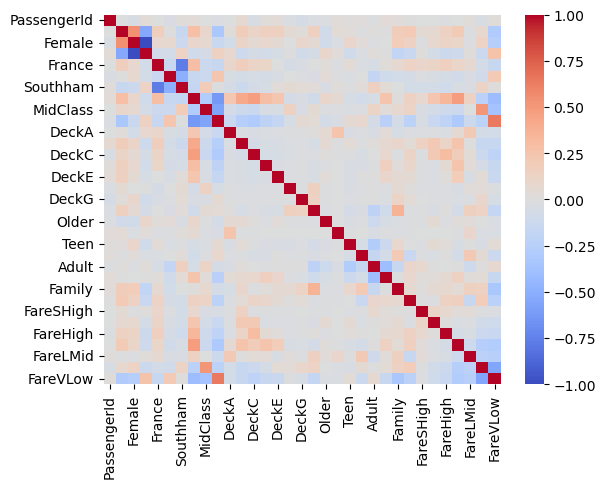

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
PassengerId,1.000000,-0.005007,-0.042939,0.042939,-0.001205,-0.033606,0.022148,0.034303,-0.000086,-0.029486,...,0.036424,0.024485,0.007036,-0.006919,-0.005924,-0.009361,-0.002941,0.017128,-0.042719,0.015639
Survived,-0.005007,1.000000,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.285904,0.093349,-0.322308,...,0.006572,0.172991,0.203889,0.050561,0.067105,0.143946,0.201847,-0.008940,0.071710,-0.295081
Female,-0.042939,0.543351,1.000000,-1.000000,0.082853,0.074115,-0.125722,0.098013,0.064746,-0.137143,...,-0.004110,0.185204,0.147900,-0.014396,0.077758,0.122850,0.107539,-0.018528,0.125753,-0.263751
Male,0.042939,-0.543351,-1.000000,1.000000,-0.082853,-0.074115,0.125722,-0.098013,-0.064746,0.137143,...,0.004110,-0.185204,-0.147900,0.014396,-0.077758,-0.122850,-0.107539,0.018528,-0.125753,0.263751
France,-0.001205,0.168240,0.082853,-0.082853,1.000000,-0.148258,-0.778359,0.296423,-0.125416,-0.153329,...,0.015701,0.066061,0.125914,0.096390,0.114332,0.158595,0.102301,0.069078,-0.072845,-0.156019
Ireland,-0.033606,0.003650,0.074115,-0.074115,-0.148258,1.000000,-0.496624,-0.155342,-0.127301,0.237449,...,-0.098545,-0.080828,-0.054904,-0.020654,-0.044163,-0.061261,-0.089749,-0.035852,-0.089171,0.205731
Southham,0.022148,-0.155660,-0.125722,0.125722,-0.778359,-0.496624,1.000000,-0.170379,0.192061,-0.009511,...,0.043355,-0.004639,-0.073577,-0.070928,-0.071466,-0.099133,-0.046560,-0.036188,0.123274,0.011096
UpperClass,0.034303,0.285904,0.098013,-0.098013,0.296423,-0.155342,-0.170379,1.000000,-0.288585,-0.626738,...,0.250065,0.015211,0.147762,0.079537,0.235222,0.338436,0.479998,0.143451,-0.229445,-0.407726
MidClass,-0.000086,0.093349,0.064746,-0.064746,-0.125416,-0.127301,0.192061,-0.288585,1.000000,-0.565210,...,0.026835,0.076022,0.117762,-0.034258,-0.073253,-0.101613,-0.130000,-0.003508,0.521150,-0.362614
WorkClass,-0.029486,-0.322308,-0.137143,0.137143,-0.153329,0.237449,-0.009511,-0.626738,-0.565210,1.000000,...,-0.237297,-0.074977,-0.223154,-0.040648,-0.143050,-0.208900,-0.307767,-0.120743,-0.226451,0.646414


In [54]:
numerical_df = strat_titanic_data.select_dtypes(include=[np.number])
#numerical_df = numerical_df.drop(["PassengerId"], axis=1)
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix

In [55]:
strat_titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
 2   Female       891 non-null    int64
 3   Male         891 non-null    int64
 4   France       891 non-null    int64
 5   Ireland      891 non-null    int64
 6   Southham     891 non-null    int64
 7   UpperClass   891 non-null    int64
 8   MidClass     891 non-null    int64
 9   WorkClass    891 non-null    int64
 10  DeckA        891 non-null    int64
 11  DeckB        891 non-null    int64
 12  DeckC        891 non-null    int64
 13  DeckD        891 non-null    int64
 14  DeckE        891 non-null    int64
 15  DeckF        891 non-null    int64
 16  DeckG        891 non-null    int64
 17  Infant       891 non-null    int64
 18  Older        891 non-null    int64
 19  VOld         891 non-null    int64
 20  Teen      

In [56]:
strat_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Female       418 non-null    int64
 2   Male         418 non-null    int64
 3   France       418 non-null    int64
 4   Ireland      418 non-null    int64
 5   Southham     418 non-null    int64
 6   UpperClass   418 non-null    int64
 7   MidClass     418 non-null    int64
 8   WorkClass    418 non-null    int64
 9   DeckA        418 non-null    int64
 10  DeckB        418 non-null    int64
 11  DeckC        418 non-null    int64
 12  DeckD        418 non-null    int64
 13  DeckE        418 non-null    int64
 14  DeckF        418 non-null    int64
 15  DeckG        418 non-null    int64
 16  Infant       418 non-null    int64
 17  Older        418 non-null    int64
 18  VOld         418 non-null    int64
 19  Teen         418 non-null    int64
 20  Child     

In [57]:
X = strat_titanic_data.drop(["Survived", "PassengerId", "Ireland"], axis=1)
y = strat_titanic_data['Survived']
Xt = strat_test_data.drop(["PassengerId", "Ireland"], axis=1)

#X, y = load_iris(return_X_y=True)
#scaler = StandardScaler()
#X_data = scaler.fit_transform(X)
#Xv_data = scaler.fit_transform(Xv)
X_data = X
Xt_data = Xt
y_data = y.to_numpy()
X, y = load_iris(return_X_y=True)
X_dataNB = X
Xt_dataNB = Xt
y_dataNB = y

In [58]:
X_data

,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
0,0,1,0,1,0,0,1,0,0,0,...,1,2,5,1,1,1,1,1,1,1
1,1,0,1,0,1,0,0,0,0,1,...,0,2,5,0,0,0,1,0,0,0
2,1,0,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
3,1,0,0,1,1,0,0,0,0,1,...,0,2,5,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,1,0,1,0,0,0,0,...,0,2,3,0,0,0,0,0,1,0
887,1,0,0,1,1,0,0,0,1,0,...,0,2,3,0,0,0,0,1,0,0
888,1,0,0,1,0,0,1,0,0,0,...,0,3,5,0,0,0,0,0,1,0
889,0,1,1,0,1,0,0,0,0,1,...,0,2,3,0,0,0,0,1,0,0


In [59]:
Xt_data

,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
0,0,1,0,0,0,0,1,0,0,0,...,1,2,3,1,1,1,1,1,1,1
1,1,0,0,1,0,0,1,0,0,0,...,1,2,5,0,0,0,0,0,0,1
2,0,1,0,0,0,1,0,0,0,0,...,1,2,3,0,0,0,0,0,0,1
3,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
4,1,0,0,1,0,0,1,0,0,0,...,0,4,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
414,1,0,1,0,1,0,0,0,0,1,...,0,2,3,0,0,1,0,0,0,0
415,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
416,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1


In [60]:
y_data

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [61]:
treeT = DecisionTreeClassifier(max_depth=10)

treeT.fit(X_data, y_data)
predict_y = treeT.predict(X_data)
predict_yt = treeT.predict(Xt_data)
predict_y = np.round(predict_y)
predict_yt = np.round(predict_yt)
predict_y = predict_y.astype(int)
predicit_yt = predict_yt.astype(int)
predicit_ytree10 = predict_yt

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
cm = confusion_matrix(y_data, predict_y)
cm

Accuracy: 0.8866442199775533 Precision: 0.9198606271777003 Recall: 0.7719298245614035 F1_score: 0.8394276629570747


array([[526,  23],
       [ 78, 264]])

In [75]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
cm = confusion_matrix(y_data, predict_y)
cm

Accuracy: 0.8866442199775533 Precision: 0.9198606271777003 Recall: 0.7719298245614035 F1_score: 0.8394276629570747


array([[526,  23],
       [ 78, 264]])

In [62]:
forestT = ensemble.RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=4)
forestT.fit(X_data, y_data)
predict_y = forestT.predict(X_data)
predict_yt = forestT.predict(Xt_data)
predict_y = np.round(predict_y)
predict_yt = np.round(predict_yt)
predict_y = predict_y.astype(int)
predicit_yt = predict_yt.astype(int)
predicit_yranF = predict_yt

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
cm = confusion_matrix(y_data, predict_y)
cm

Accuracy: 0.8439955106621774 Precision: 0.8773234200743495 Recall: 0.6900584795321637 F1_score: 0.7725040916530278


array([[516,  33],
       [106, 236]])

In [77]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
cm = confusion_matrix(y_data, predict_y)
cm

Accuracy: 0.8451178451178452 Precision: 0.8777777777777778 Recall: 0.6929824561403509 F1_score: 0.7745098039215687


array([[516,  33],
       [105, 237]])

In [63]:
class Net(nn.Module):
    def __init__(self, name=None):
        super(Net, self).__init__()
        if name:
            self.name = name
        self.fc1 = nn.Linear(30, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = x.view(-1, 30)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net(name='LetNet5')
print(net)

LetNet5: total params: 13610
Net(
  (fc1): Linear(in_features=30, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [63]:
class Net(nn.Module):
    def __init__(self, name=None, input_features=30) :
        super(Net, self).__init__()
        if name:
            self.name = name
        self.fc1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(128) # Batch normalization
        self.dropout1 = nn.Dropout(0.3) # Dropout for regularization

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(32, 2) # Output layer for binary classification (survived/not survived)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


net = Net(name='LetNet5')
print(net)

LetNet5: total params: 14818
Net(
  (fc1): Linear(in_features=30, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [64]:
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Net(
  (fc1): Linear(in_features=30, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [65]:
print(net)
X_tensor = torch.tensor(X_data.values, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.long)

# Create a custom Dataset
class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create the dataset and DataLoader
train_dataset = TitanicDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Check if CUDA is available and move the model and data to GPU if it is
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Training loop
epochs = 1300
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.6f}')
            running_loss = 0.0

print('Finished Training')

# Evaluate the trained model on the training data (optional)
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} training samples: {100 * correct / total:.2f} %')

# Evaluate on the validation set (Xt_data)
Xt_tensor = torch.tensor(Xt_data.values, dtype=torch.float32).to(device)

# Get predictions for the validation set for confusion matrix and other metrics
with torch.no_grad():
    outputs_t = net(Xt_tensor)
    _, predicted_t = torch.max(outputs_t.data, 1)
    predicted_t_np = predicted_t.cpu().numpy()

predict_yt_ann = predicted_t_np

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
cm = confusion_matrix(y_data, predict_y)
cm

Net(
  (fc1): Linear(in_features=30, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)
[1,    10] loss: 1.420616
[2,    10] loss: 1.321859
[3,    10] loss: 1.337582
[4,    10] loss: 1.281922
[5,    10] loss: 1.248051
[6,    10] loss: 1.204229
[7,    10] loss: 1.101246
[8,    10] loss: 1.011719
[9,    10] loss: 0.985375
[10,    10] loss: 0.917594
[11,    10] loss: 0.912229
[12,    10] loss: 0.992452
[13,    10] loss: 0.849303
[14,    10] loss: 0.900069
[15,    10] loss: 0.865231
[16,    10] loss: 0.844249
[17,    10] loss: 0.851823
[18,    10] loss: 0.885483
[19,    10] loss: 0.819514
[20,    10] loss: 0.846794
[21,    10] loss: 0.838879
[22,    10] loss: 0.825947
[23,    10] loss: 0.769443
[24,    10] loss: 0.783548
[25,    10] loss: 0.832895
[26,    10] loss: 0.790892
[27,    10] loss: 0.795173
[28,    10] loss: 0.796383
[29, 

array([[516,  33],
       [106, 236]])

In [86]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
cm = confusion_matrix(y_data, predict_y)
cm

Accuracy: 0.8451178451178452 Precision: 0.8777777777777778 Recall: 0.6929824561403509 F1_score: 0.7745098039215687


array([[516,  33],
       [105, 237]])

In [66]:
agree = 0
notagree = 0
for i in range(count_T):
    if (predicit_ytree10[i] == predicit_yranF[i] == predict_yt_ann[i]):
        agree+=1
    else:
        notagree+=1
agree

328

In [67]:
notagree

90

In [68]:
agree = 0
notagree = 0
predictions = np.eye(count_T, 1, dtype=int)
for i in range(count_T):
    if (predicit_ytree10[i] == predict_yt_ann[i]):
        agree+=1
    else:
        notagree+=1
        print(i, predicit_ytree10[i], predict_yt_ann[i], predicit_yranF[i])
agree

20 1 0 0
21 1 0 0
23 1 0 0
49 0 1 0
68 1 0 0
69 1 0 1
73 1 0 0
94 1 0 0
104 0 1 1
117 0 1 1
118 1 0 0
127 0 1 1
142 1 0 0
153 0 1 0
159 0 1 0
188 0 1 0
196 0 1 1
200 0 1 1
202 1 0 0
205 1 0 0
217 1 0 0
224 1 0 1
236 0 1 0
240 1 0 1
245 0 1 0
272 1 0 1
273 0 1 1
287 1 0 0
290 1 0 0
298 1 0 0
307 1 0 0
331 1 0 0
333 1 0 1
342 1 0 0
347 0 1 1
379 0 1 0
403 1 0 0
404 1 0 0
407 1 0 0


379

In [69]:
notagree

39

In [70]:
predictions = np.eye(count_T, 1, dtype=int)
for i in range(count_T):
    if (predicit_ytree10[i] == predict_yt_ann[i]):
        predictions[i] = predicit_ytree10[i]
    elif (predicit_ytree10[i] == 1) & (predicit_yranF[i] == 1):
        predictions[i] = 1
        print(i, predicit_ytree10[i], predict_yt_ann[i], predicit_yranF[i], predictions[i])
    elif (predict_yt_ann[i] == 1) & (predicit_yranF[i] == 1):
        predictions[i] = 1
        print(i, predicit_ytree10[i], predict_yt_ann[i], predicit_yranF[i], predictions[i])
    elif (predicit_ytree10[i] == 0) & (predicit_yranF[i] == 0):
        predictions[i] = 0
        print(i, predicit_ytree10[i], predict_yt_ann[i], predicit_yranF[i], predictions[i])
    elif (predict_yt_ann[i] == 0) & (predicit_yranF[i] == 0):
        predictions[i] = 0
        print(i, predicit_ytree10[i], predict_yt_ann[i], predicit_yranF[i], predictions[i])
    else:
        print(i, predicit_ytree10[i], predict_yt_ann[i], predicit_yranF[i], predictions[i])

predictions = pd.DataFrame(predictions)
predictions.value_counts()

20 1 0 0 [0]
21 1 0 0 [0]
23 1 0 0 [0]
49 0 1 0 [0]
68 1 0 0 [0]
69 1 0 1 [1]
73 1 0 0 [0]
94 1 0 0 [0]
104 0 1 1 [1]
117 0 1 1 [1]
118 1 0 0 [0]
127 0 1 1 [1]
142 1 0 0 [0]
153 0 1 0 [0]
159 0 1 0 [0]
188 0 1 0 [0]
196 0 1 1 [1]
200 0 1 1 [1]
202 1 0 0 [0]
205 1 0 0 [0]
217 1 0 0 [0]
224 1 0 1 [1]
236 0 1 0 [0]
240 1 0 1 [1]
245 0 1 0 [0]
272 1 0 1 [1]
273 0 1 1 [1]
287 1 0 0 [0]
290 1 0 0 [0]
298 1 0 0 [0]
307 1 0 0 [0]
331 1 0 0 [0]
333 1 0 1 [1]
342 1 0 0 [0]
347 0 1 1 [1]
379 0 1 0 [0]
403 1 0 0 [0]
404 1 0 0 [0]
407 1 0 0 [0]


0
0    297
1    121
Name: count, dtype: int64

In [71]:
predictions.value_counts()

0
0    297
1    121
Name: count, dtype: int64

In [72]:
predictions

,0
0,0
1,0
2,0
3,0
4,0
...,...
413,0
414,1
415,0
416,0


In [76]:
len(predicit_ytree10)

418

In [77]:
strat_test_data.iloc[21]

PassengerId    913
Female           0
Male             1
France           0
Ireland          0
Southham         1
UpperClass       0
MidClass         0
WorkClass        1
DeckA            0
DeckB            0
DeckC            0
DeckD            0
DeckE            0
DeckF            0
DeckG            0
Infant           0
Older            0
VOld             0
Teen             0
Child            1
Adult            0
MidLife          0
Family           4
Sibling          3
FareSHigh        0
FareVHigh        0
FareHigh         0
FareMid          0
FareLMid         0
FareLow          0
FareVLow         1
Name: 21, dtype: int64

In [73]:
final_df = pd.DataFrame(test_data['PassengerId'])
#final_df['Survived'] = predicit_ytree10
#final_df['Survived'] = predict_yt_ann
final_df['Survived'] = predictions
final_df.to_csv("predictions.csv", index=False)

In [74]:
final_df.head(11)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [83]:
final_df.iloc[117]

PassengerId    1009
Survived          1
Name: 117, dtype: int64

In [77]:
print(net)

Net(
  (fc1): Linear(in_features=30, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)
